# Bank Note Authentication in R

This project was completed as a part of the DSCI100 curriculum 2019-20


Over the past few decades there has been a decrease in the use of currency due to recent growth in the use of electronic transactions. However, cash transactions remain very important in the global market. Hence, there is a dire need in banks and ATM machines to implement a system that classifies a note as genuine or fake.

***Is the (unseen) banknote genuine or counterfeit?***

In this project, we will build a classifier using the **KNN classification** and evaluate the performance and predictive power of a model that has been trained and tested on data collected from bank note images. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about the authenticity of a bank note.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). Data was extracted from genuine and counterfeit banknote images using the Wavelet Transform tool. The dataset has 1372 instances and 5 variables.

For the purposes of this project, the following preprocessing steps have been made to the dataset:
- The columns in the dataset have no names so each one has been assigned a descriptive name using `colnames`
- Rows of data frame are shuffled since they are originally ordered.
- The features `'variance'`, `'skewness'`, `'curtosis'`, and `'entropy'` are all essential. There are no remaining **non-relevant features**. But we will compare models with different number of features.
- All features have been **multiplicatively scaled** to get all features on the same scale
- `'class'` is an integer so it is converted to a factor because it is the target attribute of the dataset which contains two values: 0 (genuine) and 1 (counterfeit)
- We don't have to balance the data since it already has a balanced ratio of 76:61 (genuine : counterfeit)

## Data Reading and Preprocessing
We'll start with reading in the data, and splitting the dataset for training and testing purposes.  Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [1]:
# Import libraries necessary for this project

library(expss)       # for summary table
library(tidyverse)
library(repr)
library(caret)
library(GGally)
library(ggplot2)

# Load the bank note authentication dataset
data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", col_names = FALSE)
colnames(data) <- c("variance", "skewness", "curtosis", "entropy", "class")

# Turn class variable into a factor
data <- data %>%
    mutate(class = as.factor(class))

# Shuffling rows of the data frame since they are ordered
set.seed(4321) # to make reproducible

## generate a random ordering
rand <- sample(nrow(data))

# shuffle the rows of the data frame
data <- data[rand,]

head(data)

cat("Bank note dataset has", nrow(data), "rows and", ncol(data), "columns")


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks expss::between()
✖ dplyr::compute()   masks expss::compute()
✖ dplyr::contains()  masks expss::contains()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks expss::first()
✖ stringr::fixed()   masks expss::fixed()
✖ purrr::keep()      masks expss::keep()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks expss::last()
✖ purrr::modify()    masks expss::modify()
✖ purrr::modify_if() masks expss::modify_if()
✖ dplyr::na_if()     masks expss::na_if()
✖ tidyr::nest()      masks expss::nest()
✖ dplyr::recode()    masks expss::recode()
✖ stringr::regex()   masks expss::regex()
✖ purrr::transpose() masks expss::transpose()
✖ dplyr::

variance,skewness,curtosis,entropy,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2.7365,-5.03250,6.66080,-0.57889,0
4.0972,0.46972,1.66710,0.91593,0
-2.2340,-7.03140,7.49360,0.61334,1
-1.0112,2.99840,-1.16640,-1.61850,1
6.5633,9.81870,-4.41130,-3.22580,0
-6.5235,9.60140,-0.25392,-6.96420,1


Bank note dataset has 1372 rows and 5 columns

## Data Exploration
In this section, we will make a cursory investigation about the bank note data.

Since the main goal of this project is to construct a working model which has the capability of predicting whether a bank note is **genuine** or **counterfeit**. We have separated the dataset into **training** and **testing** subsets further into *features* and the *target variable*. The **features**, `'variance'`, `'skewness'`, `'curtosis'` and `'entropy'`, give us quantitative information about each bank note. The **target variable**, `'class'`, will be the variable we seek to predict.

### Calculating Statistics

We'll start with calculating some descriptive statistics about the bank note data. We will then proceed to explore the other components of this dataframe –

In [45]:
options(repr.plot.width = 2, repr.plot.height = 2)

data %>% 
    tab_cells(variance, skewness, curtosis, entropy) %>%
    tab_cols(total(), class) %>% 
    tab_stat_mean_sd_n() %>%
    tab_last_sig_means(subtable_marks = "both") %>% 
    tab_pivot() %>% 
    set_caption("Table 1: Summary Statistics for Banknote Dataset")


Table 1: Summary Statistics for Banknote Dataset                                                             
 |          |              | #Total |     class |           |
 |          |              |        |         0 |         1 |
 |          |              |        |         A |         B |
 | -------- | ------------ | ------ | --------- | --------- |
 | variance |         Mean |    0.4 |   2.3 > B |  -1.9 < A |
 |          |    Std. dev. |    2.8 |   2.0     |   1.9     |
 |          | Unw. valid N | 1372.0 | 762.0     | 610.0     |
 | skewness |         Mean |    1.9 |   4.3 > B |  -1.0 < A |
 |          |    Std. dev. |    5.9 |   5.1     |   5.4     |
 |          | Unw. valid N | 1372.0 | 762.0     | 610.0     |
 | curtosis |         Mean |    1.4 |   0.8 < B |   2.1 > A |
 |          |    Std. dev. |    4.3 |   3.2     |   5.3     |
 |          | Unw. valid N | 1372.0 | 762.0     | 610.0     |
 |  entropy |         Mean |   -1.2 |  -1.1     |  -1.2     |
 |          |    Std. dev. |    2.1 |   2.1     |   2.1     |
 |          | Unw. valid N | 1372.0 | 762.0     | 610.0     |

In [3]:
# dimension of the banknote data set
dim(data)

[1] 1372    5

In [4]:
# distribution of the target attribute 'class'
table(data$class)


  0   1 
762 610 

### EDA
We will plot box plots and scatter plots to understand the extent of correlation among features.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-7.0421 -1.7730  0.4962  0.4337  2.8215  6.8248 

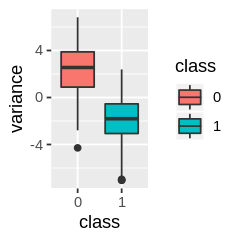

In [5]:
options(repr.plot.width = 2, repr.plot.height = 2)

#Variance
ggplot(data, aes(x=class, y=variance, fill = class)) + 
  geom_boxplot() 
summary(data$variance) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-13.773  -1.708   2.320   1.922   6.815  12.952 

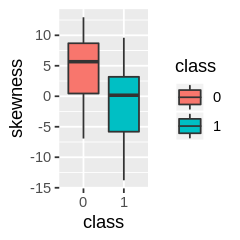

In [6]:
options(repr.plot.width = 2, repr.plot.height = 2)

#Skewness
ggplot(data, aes(x=class, y=skewness, fill = class)) + 
  geom_boxplot() 
summary(data$skewness)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.5482 -2.4135 -0.5867 -1.1917  0.3948  2.4495 

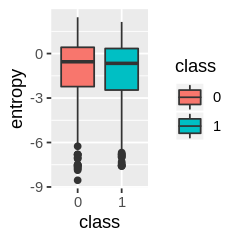

In [7]:
options(repr.plot.width = 2, repr.plot.height = 2)

#Entropy
ggplot(data, aes(x=class, y=entropy, fill = class)) + 
  geom_boxplot() 
summary(data$entropy)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.2861 -1.5750  0.6166  1.3976  3.1793 17.9274 

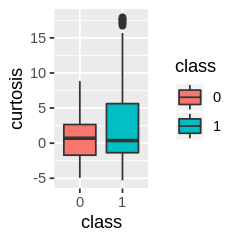

In [8]:
options(repr.plot.width = 2, repr.plot.height = 2)

#Curtosis
ggplot(data, aes(x=class, y=curtosis, fill = class)) + 
  geom_boxplot() 
summary(data$curtosis)

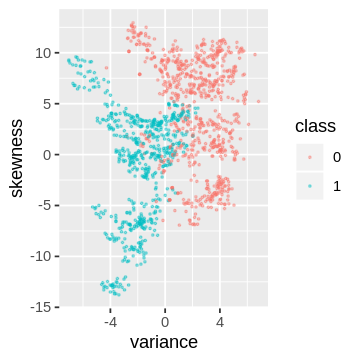

In [9]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Skewness vs Variance
ggplot(data, aes(x=variance, y=skewness, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4) 

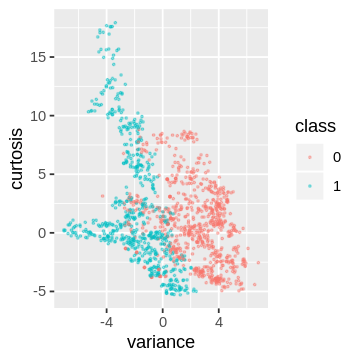

In [10]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Curtosis vs Variance
ggplot(data, aes(x=variance, y=curtosis, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4) 

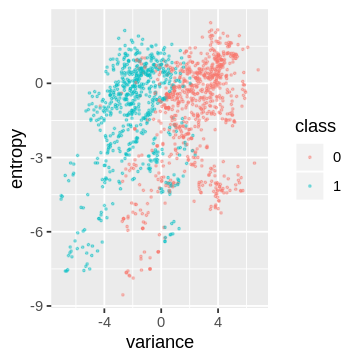

In [11]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Entropy vs Variance
ggplot(data, aes(x=variance, y=entropy, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4)  

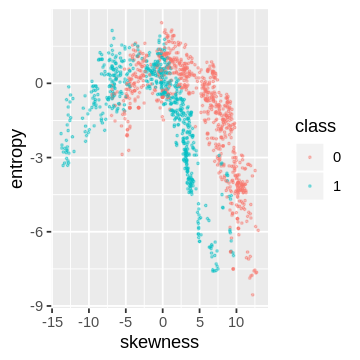

In [12]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Entropy vs Skewness
ggplot(data, aes(x=skewness, y=entropy, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4)  

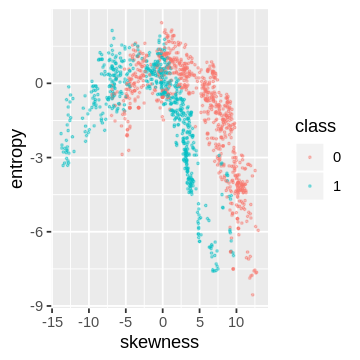

In [13]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Entropy vs Skewness
ggplot(data, aes(x=skewness, y=entropy, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4)  

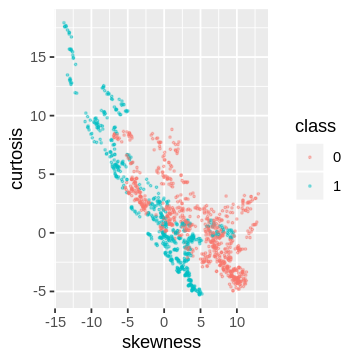

In [14]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Curtosis vs Skewness
ggplot(data, aes(x=skewness, y=curtosis, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4)  

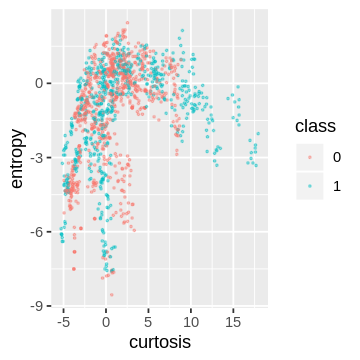

In [15]:
options(repr.plot.width = 3, repr.plot.height = 3)

#Entropy vs Curtosis
ggplot(data, aes(x=curtosis, y=entropy, colour = class)) + 
  geom_point(size = 0.4, alpha = 0.4)  

> We see that the first two plots i.e. variance vs skewness and curtosis vs variance are the most fitting plots which drives the model because we see two clusters almost completely separated i.e. we have a balanced relationship. While others have bit of a overlap so if we choose an observation at the center of the data it can get difficult to predict its class using K nearest neighbours. In order to be sure we will plot a scatterplot matrix using training data to see and compare the correlation coefficients of the above two plots.

## Data Modeling
We will split our dataset into training set as well as test set with a split ratio of 0.75. This means that 75% of our data will be attributed to the train whereas 25% will be attributed to the test data. By spitting a dataset into training and testing subsets, we can train our model on the training subset, and then feed it with unseen data from the test subset to evaluate the performance of our model. 
### Splitting the Data
 The instances are divided into training and testing subsets. There are 1032 instances for training and 340 instances for testing.
We will then find the dimensions using the dim() function –

In [16]:
# dividing the data set into a training set and a test set
# keeping 75 % of the data to train on
set.seed(4321)

training_rows <- data %>% 
  select(class) %>% 
  unlist() %>%
  createDataPartition(p = 0.75, list = FALSE)

train <- data %>% 
  select(variance, skewness, curtosis, entropy, class) %>% 
  slice(training_rows) %>% 
  data.frame()

test <- data %>% 
  select(variance, skewness, curtosis, entropy, class) %>% 
  slice(-training_rows) %>% 
  data.frame()

In [17]:
#dimension of testing data
dim(test)

[1] 342   5

In [18]:
#dimension of training data
dim(train)

[1] 1030    5

#### Data Manipulation
We will scale our data using the scale() function. We will apply this to all variables. Scaling is also known as feature standardization. With the help of scaling, the data is structured according to a specified range. Therefore, there are no extreme values in our dataset that might interfere with the functioning of our model. We will carry this out as follows:

In [19]:
set.seed(4321)

X_train <- data %>% 
  select(variance, skewness, curtosis, entropy) %>% 
  slice(training_rows) %>% 
  data.frame()

# scaling the traning data set
X_train <- X_train %>%
   scale(center = FALSE)

Y_train <- data %>% 
  select(class) %>% 
  slice(training_rows) %>% 
  unlist()

X_test <- data %>% 
  select(variance, skewness, curtosis, entropy) %>% 
  slice(-training_rows) %>% 
  data.frame()

# scaling the testing data set
X_test <- X_test %>%
   scale(center = FALSE)

Y_test <- data %>% 
  select(class) %>% 
  slice(-training_rows) %>% 
  unlist()

head(train)

variance,skewness,curtosis,entropy,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2.73650,-5.03250,6.6608,-0.57889,0
-2.23400,-7.03140,7.4936,0.61334,1
6.56330,9.81870,-4.4113,-3.22580,0
3.88460,-3.03360,2.5334,0.20214,0
0.88298,0.66009,6.0096,-0.43277,0
0.62120,3.67710,-4.0771,-2.07110,1


### Feature Observation

To dive a bit deeper into our data, we are using four features from the Bank note dataset: `'variance'`, `'skewness'`, `'curtosis'` and `'entropy'`. For each data point (bank note):
- `'variance'` finds how each pixel varies from the neighboring pixels and classifies them into different regions.
- `'skewness'` is the measure of the lack of symmetry.
- `'curtosis'` is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
- `'entropy'` is a quantity which is used to describe the amount of information which must be coded for, by a compression algorithm.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


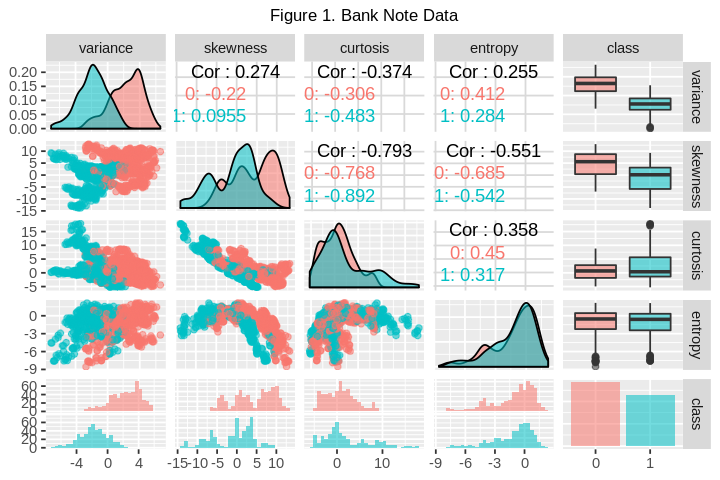

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggpairs(train, title = "Figure 1. Bank Note Data",mapping = ggplot2::aes(colour = class, alpha = 0.4)) +
theme(plot.title = element_text(size = 10 ,hjust = 0.5)) 

> #### Understanding the ggpairs plot
The plot above (figure 1) visualize the relationship between the features in our data set (training set). It can be seen that some of the features would work better together for separating the data than others. Taking entropy and curtosis as an example where the two classes are more or less just stacked on top of each other and variance and skewness as an example where the two classes are almost linearly separable. We use this visualisation to decide which variables to include and which not to include in our model.



----

## Tuning the KNN Classifier
In this section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Cross Validation and Parameter value selection
Finding the best k for KNN by varying k from 1 to 100 in increment of 2.

In [21]:
set.seed(4321) # for reproducible result
ks = data.frame(k = seq(from = 1, to = 100, by = 2))

train_ctrl = trainControl(method = "cv", number = 10)
choose_k_model <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_ctrl)

choose_k_model

k-Nearest Neighbors 

1030 samples
   4 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 927, 927, 927, 927, 927, 927, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9990291  0.9980400
   3  1.0000000  1.0000000
   5  1.0000000  1.0000000
   7  1.0000000  1.0000000
   9  1.0000000  1.0000000
  11  0.9970874  0.9941444
  13  0.9970874  0.9941444
  15  0.9922235  0.9843123
  17  0.9903004  0.9804317
  19  0.9893295  0.9784799
  21  0.9893295  0.9784799
  23  0.9893295  0.9784799
  25  0.9893295  0.9784799
  27  0.9893295  0.9784799
  29  0.9893295  0.9784799
  31  0.9883587  0.9765199
  33  0.9883587  0.9765199
  35  0.9883587  0.9765199
  37  0.9883587  0.9765199
  39  0.9883587  0.9765199
  41  0.9883587  0.9765199
  43  0.9883587  0.9765199
  45  0.9873878  0.9745680
  47  0.9883587  0.9765199
  49  0.9883587  0.9765199
  51  0.9873878  0.9745680
  53  0.9873878  0.9745680
  55  

### Analyzing Model Performance
#### Plot of k vs Accuracy
We see above and in the plot as well that k = 3, 5, 7, 9 have 100% accuracy but we are choosing k = 7 because we get optimal accuracy. Also our model will likely be accurate changing the value to a nearby one doesn’t decrease accuracy too much, so that our choice is reliable in the presence of uncertainty. The cost of training will not be very expensive beacuse K value is not unreasonably large.

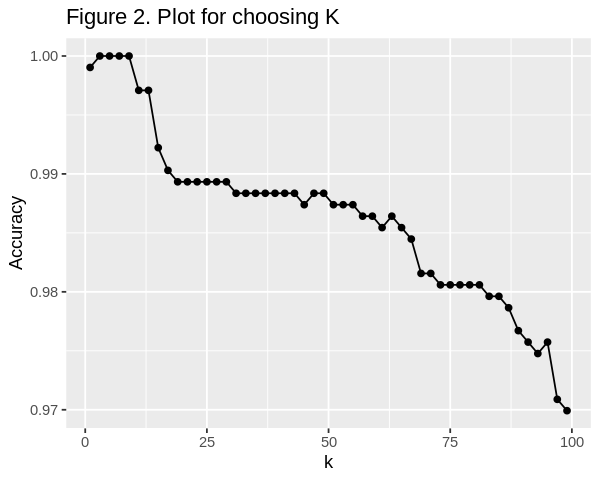

In [22]:
options(repr.plot.width = 5, repr.plot.height = 4)
k_accuracies <- choose_k_model$results %>%
                    select(k, Accuracy)
choose_k_plot <- ggplot(k_accuracies, aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 2. Plot for choosing K")
choose_k_plot

> There can be a problem of **overfitting**, i.e. the model can be really accurate on the training data, but perform poorly on the testing data. When trying to choose the best value of k it can be seen in the plot that there is a tie between k = 3, 5, 7 and 9 for the best accuracy. K is therefore set to 7 to minimize the overfitting of the model.

-----

## Evaluating Model Performance
In this section of the project, we will construct models with different number of features and compare them by making predictions and evaluating their accuracies.

#### 1. Fitting a Model with all 4 features
Fitting the model with best k = 7 using all 4 features namely, variance, entropy, curtosis, and skewness.

In [23]:
set.seed(4321)
best_k = data.frame(k=7)
best_model <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = best_k)
best_model

k-Nearest Neighbors 

1030 samples
   4 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1030, 1030, 1030, 1030, 1030, 1030, ... 
Resampling results:

  Accuracy   Kappa    
  0.9987501  0.9974684

Tuning parameter 'k' was held constant at a value of 7

##### Making Predictions


In [24]:
Y_test_predicted <- predict(best_model, X_test)
model_quality <- confusionMatrix(Y_test_predicted, Y_test)
model_quality
model_quality$overall[1]

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 189   0
         1   1 152
                                          
               Accuracy : 0.9971          
                 95% CI : (0.9838, 0.9999)
    No Information Rate : 0.5556          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9941          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9947          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9935          
             Prevalence : 0.5556          
         Detection Rate : 0.5526          
   Detection Prevalence : 0.5526          
      Balanced Accuracy : 0.9974          
                                          
       'Positive' Class : 0               
                              

Accuracy 
0.997076

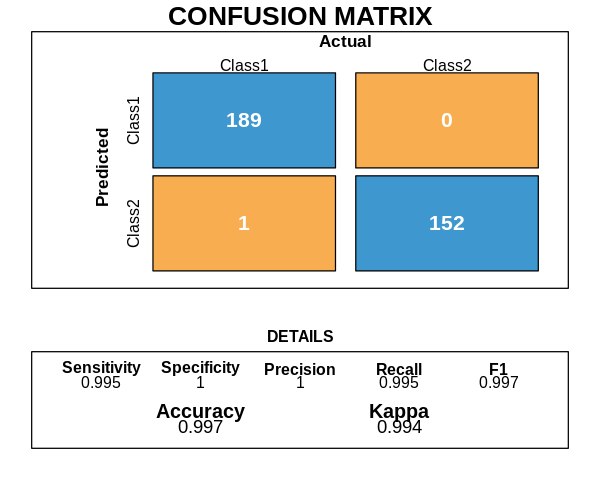

In [25]:
# code for visualizing our confusion matrix from stackoverflow

draw_confusion_matrix <- function(model_quality) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Class1', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Class2', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Class1', cex=1.2, srt=90)
  text(140, 335, 'Class2', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(model_quality$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')
    
    # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(model_quality$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(model_quality$byClass[1]), 3), cex=1.2)
  text(30, 85, names(model_quality$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(model_quality$byClass[2]), 3), cex=1.2)
  text(50, 85, names(model_quality$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(model_quality$byClass[5]), 3), cex=1.2)
  text(70, 85, names(model_quality$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(model_quality$byClass[6]), 3), cex=1.2)
  text(90, 85, names(model_quality$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(model_quality$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(model_quality$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(model_quality$overall[1]), 3), cex=1.4)
  text(70, 35, names(model_quality$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(model_quality$overall[2]), 3), cex=1.4)
}  

draw_confusion_matrix(model_quality)

#### 2. Fitting a model with 3 features
In this section another model is being fitted to the training data and then used to predict on the test data. This is done as a response of the ggpairs plot in which entropy seemed like the worst variable for distinguishing genuine banknotes from fake ones.

In [26]:
# creating a data frame for trying the three best looking variables from the pairs plot 
try_three_variables_data <- data

In [27]:
# selecting the variables needed for the analysis
try_three_variables_data <- try_three_variables_data %>%
    select(variance, skewness, curtosis, class)

In [28]:
# dividing the data set into a training set and a test set
# keeping 75 % of the data to train on

set.seed(4321) # to make reproducible

training_rows <- try_three_variables_data %>% 
  select(class) %>% 
  unlist() %>%
  createDataPartition(p = 0.75, list = FALSE)

X_train_3 <- try_three_variables_data %>% 
  select(variance, skewness, curtosis) %>% 
  slice(training_rows) %>% 
  data.frame()

# scaling the traning data set
X_train_3 <- X_train_3 %>%
   scale(center = FALSE)

Y_train_3 <- try_three_variables_data %>% 
  select(class) %>% 
  slice(training_rows) %>% 
  unlist()

X_test_3 <- try_three_variables_data %>% 
  select(variance, skewness, curtosis) %>% 
  slice(-training_rows) %>% 
  data.frame()

# scaling the test data set
X_test_3 <- X_test_3 %>%
    scale(center = FALSE)

Y_test_3 <- try_three_variables_data %>% 
  select(class) %>% 
  slice(-training_rows) %>% 
  unlist()

In [29]:
# 10-fold cross validation to choose k
set.seed(4321) # to make reproducible

ks = data.frame(k = seq(from = 1, to = 100, by = 2))

train_ctrl = trainControl(method = "cv", number = 10)

choose_k_model <- train(x = X_train_3, y = Y_train_3, method = "knn", tuneGrid = ks, trControl = train_ctrl)

k_accuracies <- choose_k_model$results %>%
                    select(k, Accuracy)

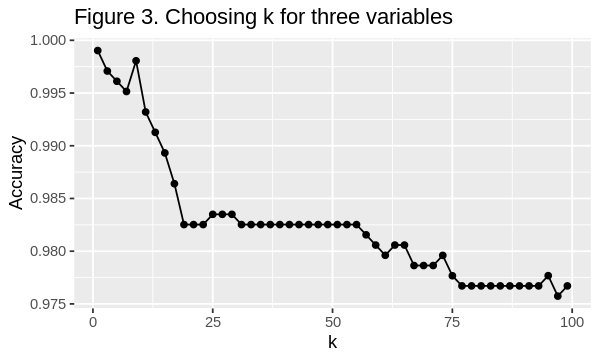

In [30]:
options(repr.plot.width = 5, repr.plot.height = 3)

choose_k_plot <- ggplot(k_accuracies, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 3. Choosing k for three variables")
choose_k_plot

When trying to choose the best value of k it can be seen in the plot that k = 1 has the best accuracy. K is therefore set to 9 to ***minimize the overfitting of the model***.

In [31]:
# Choosing the best k that is not equal to 1
set.seed(4321)
best_k = data.frame(k=9)
best_model <- train(x = X_train_3, y = Y_train_3, method = "knn", tuneGrid = best_k)
best_model

k-Nearest Neighbors 

1030 samples
   3 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1030, 1030, 1030, 1030, 1030, 1030, ... 
Resampling results:

  Accuracy   Kappa    
  0.9938481  0.9875454

Tuning parameter 'k' was held constant at a value of 9

In [32]:
Y_test_predicted <- predict(best_model, X_test_3)
model_quality <- confusionMatrix(Y_test_predicted, Y_test_3)
model_quality
model_quality$overall[1]

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 188   0
         1   2 152
                                         
               Accuracy : 0.9942         
                 95% CI : (0.979, 0.9993)
    No Information Rate : 0.5556         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9882         
                                         
 Mcnemar's Test P-Value : 0.4795         
                                         
            Sensitivity : 0.9895         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9870         
             Prevalence : 0.5556         
         Detection Rate : 0.5497         
   Detection Prevalence : 0.5497         
      Balanced Accuracy : 0.9947         
                                         
       'Positive' Class : 0              
                                         

Accuracy 
0.994152

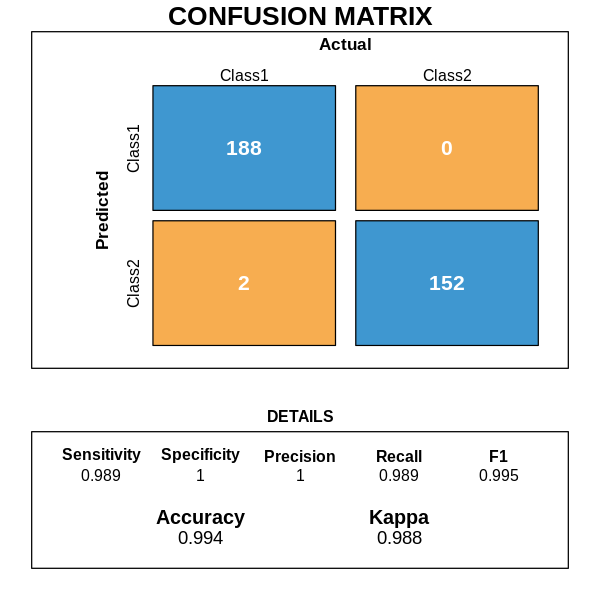

In [33]:
options(repr.plot.width = 5, repr.plot.height = 5)
draw_confusion_matrix(model_quality)

#### 3. Fitting a model with 2 features (variance, skewness)

In this section one more variable is removed from the model (curtosis is removed due to information in the ggpairs plot).

In [34]:
# creating a data frame for trying the two best looking vairables from the pairs plot 
try_two_variables_data <- data

In [35]:
# selecting the variables needed for the analysis
try_two_variables_data <- try_two_variables_data %>%
    select(variance, skewness, class)

In [36]:
# dividing the data set into a training set and a test set
# keeping 75 % of the data to train on

set.seed(4321) # to make reproducible

full_data_x <- try_two_variables_data %>% 
    select(variance, skewness) %>%
    data.frame()

full_data_y <- try_two_variables_data %>% 
  select(class) %>% 
  unlist() 

training_rows <- try_two_variables_data %>% 
  select(class) %>% 
  unlist() %>%
  createDataPartition(p = 0.75, list = FALSE)

X_train_2 <- try_two_variables_data %>% 
  select(variance, skewness) %>% 
  slice(training_rows) %>% 
  data.frame()

# scaling the traning data set
X_train_2 <- X_train_2 %>%
   scale(center = FALSE)

Y_train_2 <- try_two_variables_data %>% 
  select(class) %>% 
  slice(training_rows) %>% 
  unlist()

X_test_2 <- try_two_variables_data %>% 
  select(variance, skewness) %>% 
  slice(-training_rows) %>% 
  data.frame()

# scaling the test data set
X_test_2 <- X_test_2 %>%
    scale(center = FALSE)

Y_test_2 <- try_two_variables_data %>% 
  select(class) %>% 
  slice(-training_rows) %>% 
  unlist()

In [37]:
# 10-fold cross validation to choose k

set.seed(4321) # to make reproducible

ks = data.frame(k = seq(from = 1, to = 100, by = 2))

train_ctrl = trainControl(method = "cv", number = 10)

choose_k_model <- train(x = X_train_2, y = Y_train_2, method = "knn", tuneGrid = ks, trControl = train_ctrl)

k_accuracies <- choose_k_model$results %>%
                    select(k, Accuracy)

choose_k_model

k-Nearest Neighbors 

1030 samples
   2 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 927, 927, 927, 927, 927, 927, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9379007  0.8744265
   3  0.9378818  0.8740503
   5  0.9272300  0.8525472
   7  0.9301333  0.8586312
   9  0.9339511  0.8668549
  11  0.9339700  0.8669014
  13  0.9378348  0.8750228
  15  0.9397765  0.8789518
  17  0.9378443  0.8750652
  19  0.9349220  0.8692679
  21  0.9368544  0.8731976
  23  0.9368451  0.8733749
  25  0.9359024  0.8712838
  27  0.9339606  0.8674427
  29  0.9359026  0.8713769
  31  0.9378443  0.8753375
  33  0.9368734  0.8734260
  35  0.9329899  0.8656404
  37  0.9291064  0.8580295
  39  0.9252134  0.8502266
  41  0.9261843  0.8521229
  43  0.9290969  0.8579260
  45  0.9300678  0.8598589
  47  0.9281261  0.8560259
  49  0.9271552  0.8540504
  51  0.9281261  0.8559784
  53  0.9290969  0.8579220
  55  

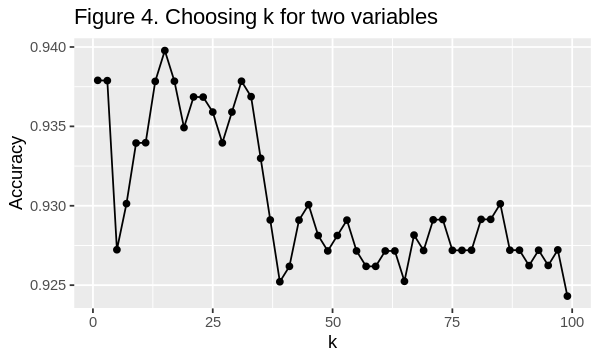

In [38]:
options(repr.plot.width = 5, repr.plot.height = 3)
choose_k_plot <- ggplot(k_accuracies, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 4. Choosing k for two variables")
choose_k_plot

In [39]:
# Choosing the best k that is not equal to 1
set.seed(4321)
best_k = data.frame(k=15)
best_model <- train(x = X_train_2, y = Y_train_2, method = "knn", tuneGrid = best_k)
best_model

k-Nearest Neighbors 

1030 samples
   2 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1030, 1030, 1030, 1030, 1030, 1030, ... 
Resampling results:

  Accuracy   Kappa    
  0.9286054  0.8561315

Tuning parameter 'k' was held constant at a value of 15

In [40]:
Y_test_predicted <- predict(best_model, X_test_2)
model_quality <- confusionMatrix(Y_test_predicted, Y_test_2)
model_quality
model_quality$overall[1]

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 172   7
         1  18 145
                                         
               Accuracy : 0.9269         
                 95% CI : (0.894, 0.9521)
    No Information Rate : 0.5556         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.853          
                                         
 Mcnemar's Test P-Value : 0.0455         
                                         
            Sensitivity : 0.9053         
            Specificity : 0.9539         
         Pos Pred Value : 0.9609         
         Neg Pred Value : 0.8896         
             Prevalence : 0.5556         
         Detection Rate : 0.5029         
   Detection Prevalence : 0.5234         
      Balanced Accuracy : 0.9296         
                                         
       'Positive' Class : 0              
                                         

Accuracy 
0.9269006

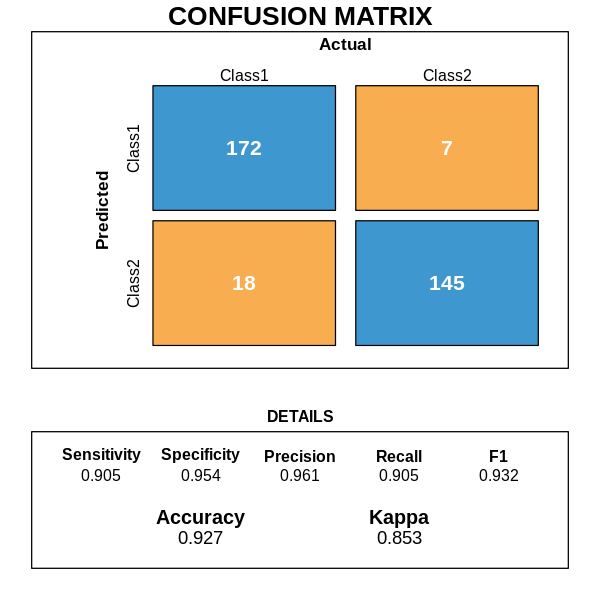

In [41]:
options(repr.plot.width = 5, repr.plot.height = 5)
draw_confusion_matrix(model_quality)

#### Fitting the model with the best k = 15

In [42]:
best_k = data.frame(k=15)
best_model <- train(x = full_data_x, y = full_data_y, method = "knn", tuneGrid = best_k)
best_model

k-Nearest Neighbors 

1372 samples
   2 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1372, 1372, 1372, 1372, 1372, 1372, ... 
Resampling results:

  Accuracy   Kappa    
  0.9308948  0.8603165

Tuning parameter 'k' was held constant at a value of 15

#### Training the KNN classifier with 2 features

In [43]:
#train the knn classifier
    k <- data.frame(k = 15)
    model_knn <- best_model

#code for visualizing our decision plot from stackoverflow
    #create a prediction pt grid
    con_grid <- seq(min(try_two_variables_data$variance), max(try_two_variables_data$variance), length.out = 100)
    smo_grid <- seq(min(try_two_variables_data$skewness), max(try_two_variables_data$skewness), length.out = 100)
    csgrid <- expand.grid(variance=con_grid, skewness=smo_grid)
    knnPredGrid <- predict(model_knn, newdata=csgrid)
    prediction_table <- bind_cols(csgrid, data.frame(class=knnPredGrid))
   
    
    #create the basic plt
    plot1 <- ggplot() + 
        geom_point(data = prediction_table, mapping=aes(x = variance, y = skewness, color = class), alpha=0.05, size=3.)+
        geom_point(data = try_two_variables_data , mapping=aes(x = variance, y = skewness, color = class), alpha=0.75) +
        labs(color = "Class", title = "Figure 5. Decision boundary plot") +
        scale_color_manual(values = c("skyblue3", "tomato1"),labels = c("Genuine", "Counterfeit"))



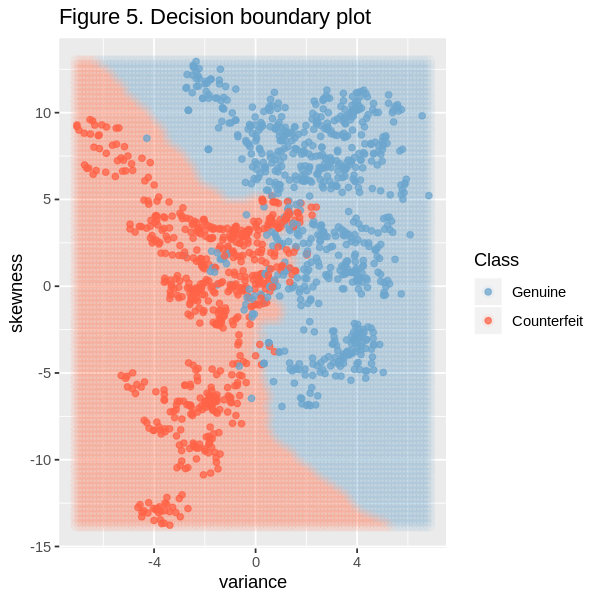

In [44]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot1

##### Understanding the Decision Boundary plot

In figure 5 the decision boundary for the model with two variables trained on the full data set is plotted against the labeled data points from the data set. Setting the background colour of each area of our (balanced data) scatter plot to the decision the K-nearest neighbour classifier would make, we can see that the decision is more reasonable; when the points are close to those labelled 0 (genuine), the classifier predicts a genuine banknote and vice versa.

### Discussion


> **Findings**
 - The KNN-model constructed is performing very good on both traning data as well as testing data.
 - The model with 4 predicted variables (variance, skewness, curtosis, entropy) has an unusal high accuracy (99.7 %).
 - The model with 3 predicted variables (variance, skewness, curtosis) also has a high accuracy (99.4%).
 - The model with 2 predicted variables (variance, skewness) has a good accuracy (92.6%).
 - It can be seen that removing "entropy" as a feature when constructing the KNN-model only affect the accuracy of the model by a fraction.

> **Which Model is the Best?**
- By comparing and contrasting the three models that we have built, we believe the model with ***3 features is the best choice*** to be implemented in ATM’s and self-service payment kiosks. 
- Firstly, the accuracy of the model with 3 features is as high as the one of model with 4 features, which is much higher than the model with only 2 features. 
- Secondly, it is also cheaper for implementation in real life than the 4-variables model. 
- We can say that the 2 feature model is also good in terms of cost and a decent accuracy rate (~ 93%). It can be used by small enterprises or banks.

> **Impact**
 - Distinguishing genuine and counterfeit banknotes.
 - Useful for blind and partially sighted people to know both the value and authenticity of banknotes.
 
> **Future Outlook**
 - Focus on automatic adaption of the redundant Wavelet Transform and classification to establish dependable analytical authenticity method that is independent of currency or denomination.
 - Colour and texture features of bank notes can be taken into account.
 - Worn and wrinkled notes to be collected to equip the system to identify these notes.

###  References
- Shahani, S., Jagiasi, A., & Priya, R. L. Analysis of Banknote Authentication System using Machine Learning Techniques. *International Journal of Computer Applications*, 975, 8887.
- Jaiswal, R., & Jaiswal, S. Banknote Authentication using Random Forest Classifier.
- https://stackoverflow.com/questions/23891140/r-how-to-visualize-confusion-matrix-using-the-caret-package/42940553